<h1>Notebook for Training, Evaluation and Inference on CenterNet (with ResNet-101-v1 and FPN) using TensorFlow Object Detection API </h1>

<strong><u>Notes</strong></u>:
1. Last checked compatible TensorFlow version: 2.10.0
2. There might be compatibility issues with other packages if TensorFlow deprecates certain functions in future releases. Please update accordingly.
3. Image Preprocessing: TensorFlow Object Detection API takes input in the form of TFRecords. This step is not included in this Notebook and has to be performed separately. We used Roboflow for this purpose.
4. To train or evaluate the model using older checkpoints, just change the "model_checkpoint_path" in the "checkpoint" file to the name of the checkpoint you want to use.
5. Input size = 512x512

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

Mounted at /content/drive


#Cloning TF models repo

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models
  

Cloning into 'models'...
remote: Enumerating objects: 3484, done.
remote: Counting objects: 100% (3484/3484), done.
remote: Compressing objects: 100% (2906/2906), done.
remote: Total 3484 (delta 904), reused 1518 (delta 525), pack-reused 0
Receiving objects: 100% (3484/3484), 46.92 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (904/904), done.


#Compiling Protos and Installing TF Object Detection API

In [ ]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --use-feature=2020-resolver .

Process is terminated.


In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools tf_slim


import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

#Required Imports

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
import os
import numpy as np
import random
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

#Installing the comptabile OpenCV verison

In [ ]:
!pip install "opencv-python-headless<4.3"
import cv2 as cv

In [ ]:
print(cv.__version__)

In [ ]:
import io
import imageio
import glob
import scipy.misc
from six import BytesIO

#Importing Object Detection utilities

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

#Installing LibcuDNN

In [ ]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

#Paths

In [ ]:
#PLEASE CHANGE PATHS AS REQUIRED

dataset_used = 'Main_dataset_512'
train_record_path = '/content/drive/My Drive/BoneJoints/'+dataset_used+'/train/joints.tfrecord'
model_dir = '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/training'
labelmap_path = '/content/drive/My Drive/BoneJoints/'+dataset_used+'/train/joints_label_map.pbtxt'
valid_record_path = '/content/drive/My Drive/BoneJoints/'+dataset_used+'/test/joints.tfrecord'
default_config_path = '/content/centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/pipeline.config' 
pipeline_config_path = '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/training/pipeline.config'
checkpoint_path = '/content/checkpoint/ckpt-0'

In [ ]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz"
!tar -xf centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz

os.makedirs('/content/checkpoint/') #to check
!mv centernet_resnet101_v1_fpn_512x512_coco17_tpu-8/checkpoint /content/

--2022-09-23 20:10:56--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.124.128, 2607:f8b0:4001:c14::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.124.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345992335 (330M) [application/x-tar]
Saving to: ‘centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz’

centernet_resnet101 100%[===================>] 329.96M   146MB/s    in 2.3s    

2022-09-23 20:10:58 (146 MB/s) - ‘centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz’ saved [345992335/345992335]



#Hyperparameters

In [ ]:
num_classes = 4
batch_size = 8
train_steps = 5000
num_epochs = 2000 #to keep LR as close to initial as possible, since cosine decay is used by TF OD API by default
eval_steps = 1500
optimizer = 'Adam'
learning_rate = 0.001
warmup_lr = learning_rate
num_images = 3413
checkpoint_type = "detection"

In [ ]:
def num_step_calc():
  steps_per_epoch = num_images/batch_size
  num_steps = num_epochs*steps_per_epoch
  return num_steps

train_steps = int(num_step_calc())
print(train_steps)

853250


#Dynamically editing Pipeline Config using Protocol Buffer API

In [ ]:
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

configs = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          

with tf.io.gfile.GFile(default_config_path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, configs)


configs.model.center_net.num_classes = num_classes
configs.model.center_net.object_center_params.min_box_overlap_iou=0.6

configs.train_config.batch_size = batch_size
configs.train_config.num_steps = train_steps
configs.train_config.fine_tune_checkpoint = checkpoint_path
configs.train_config.fine_tune_checkpoint_type = checkpoint_type

configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = learning_rate
configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = train_steps
configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = warmup_lr
configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.warmup_steps = 1


configs.train_input_reader.label_map_path = labelmap_path
configs.train_input_reader.tf_record_input_reader.input_path[:] = [train_record_path] 


configs.eval_input_reader[0].label_map_path = labelmap_path
configs.eval_input_reader[0].tf_record_input_reader.input_path[:] = [valid_record_path]

config_text = text_format.MessageToString(configs)                                                                                                                                                                                                        
with tf.io.gfile.GFile(pipeline_config_path, "wb") as f:
  f.write(config_text)

#Training the Model

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={train_steps} \
    --num_eval_steps={eval_steps}

2022-09-08 17:34:38.910572: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0908 17:34:38.915960 139640341608320 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 853250
I0908 17:34:38.920211 139640341608320 config_util.py:552] Maybe overwriting train_steps: 853250
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0908 17:34:38.920410 139640341608320 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0908 17:34:38.953719 139640341608320 cross_device_ops.py:618] Reduce to /job:localhost/repl

#Evaluating the Model

##COCO Metrics

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir}

W0912 11:55:48.064563 139856852383616 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0912 11:55:48.064813 139856852383616 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0912 11:55:48.064905 139856852383616 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0912 11:55:48.065002 139856852383616 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0912 11:55:48.065136 139856852383616 model_lib_v2.py:1110] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-09-12 11:55:48.839196: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config 

#Visualizing using Tensorboard

##Training visualizer

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/training/train/"

##Evaluation visualizer

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/training/eval/"

#Exporting Inference Graph and saving best model

##Exporting Inference Graph

In [ ]:
output_directory = 'inference_graph'


!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

2022-09-19 21:54:12.419303: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0919 21:54:19.836849 140080380729216 deprecation.py:628] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0919 21:54:28.752246 1400803807292

##Creating Saved Model zip

In [ ]:
%%bash
cp /content/drive/MyDrive/BoneJoints/Main_dataset_512/train/joints_label_map.pbtxt /content/inference_graph/saved_model/
zip -r /content/saved_model.zip /content/inference_graph/saved_model/

updating: content/inference_graph/saved_model/ (stored 0%)
updating: content/inference_graph/saved_model/variables/ (stored 0%)
updating: content/inference_graph/saved_model/variables/variables.index (deflated 80%)
updating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/inference_graph/saved_model/saved_model.pb (deflated 92%)
updating: content/inference_graph/saved_model/assets/ (stored 0%)
  adding: content/inference_graph/saved_model/joints_label_map.pbtxt (deflated 67%)


##Copying saved model TO drive

In [ ]:
!cp -avr /content/saved_model.zip /content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/

'/content/saved_model.zip' -> '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/saved_model.zip'


#Inference on Random Images

##Importing utils

In [ ]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2022-09-23 19:14:16--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0s      

2022-09-23 19:14:17 (36.2 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



##Copying saved model FROM drive

In [ ]:
!cp -avr /content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/saved_model.zip ./

'/content/drive/MyDrive/BoneJoints/Model_Checkpoints/CenterNet_ResNet101v1_FPN_512/saved_model.zip' -> '/content/saved_model.zip'


##Unzipping saved model

In [ ]:
%%bash
unzip ./saved_model.zip

Archive:  /content/saved_model.zip
   creating: content/inference_graph/saved_model/
   creating: content/inference_graph/saved_model/variables/
  inflating: content/inference_graph/saved_model/variables/variables.index  
  inflating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
  inflating: content/inference_graph/saved_model/saved_model.pb  
   creating: content/inference_graph/saved_model/assets/
  inflating: content/inference_graph/saved_model/joints_label_map.pbtxt  


##Loading model

In [ ]:
output_directory = 'inference_graph/'
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/content/{output_directory}/saved_model')

##Running Inference

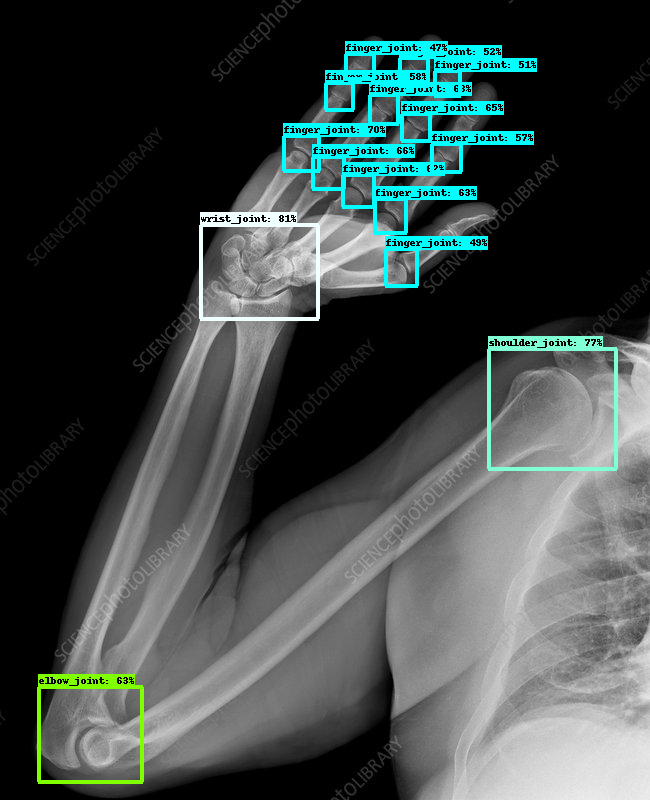

In [ ]:
image_names = [] #Enter links to inference images here

num_images = len(image_names)
image_np = load_image_into_numpy_array(image_names[0])
output_dict = run_inference_for_single_image(model, image_np)

vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    min_score_thresh=.4,   #Change minimum confidence threshold
    line_thickness=4)      #Change thickness of bounding boxes edges
display(Image.fromarray(image_np))